In [1]:
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict, Counter

from mc import MarkovChain

In [2]:
def _calculate_markov_chain(sequences, assignment, n_clusters):
    markov_chains = [MarkovChain() for _ in range(n_clusters)]
    for sequence in sequences:
        markov_chains[assignment[tuple(sequence)]].add_sequence(sequence)
    return markov_chains
                
def sequence_clustering(sequences, n_clusters=2):
    # http://web.ist.utl.pt/diogo.ferreira/papers/ferreira07approaching.pdf
    
    # Initialization: we initialize two random markov chains
    cluster_initialization = np.random.choice(range(n_clusters), size=len(sequences))
    initial_assignment = {}
    for i, sequence in enumerate(sequences): 
        initial_assignment[tuple(sequence)] = cluster_initialization[i]
        
    markov_chains = _calculate_markov_chain(sequences, initial_assignment, n_clusters)
        
    # Now until there is (almost) no change:
    #     Iterate over all sequences and assign sequence to markov chain with highest likelihood (E)
    #     Recalculate the markov chains by using the assigned sequences (M)
    prev_assignment = None
    assignment = None
    while assignment == None or assignment != prev_assignment:
        prev_assignment = assignment
        assignment = {}
        for sequence in sequences:
            assignment[tuple(sequence)] = np.argmax([mc.get_probability(sequence) for mc in markov_chains])
            
        markov_chains = _calculate_markov_chain(sequences, assignment, n_clusters)
        
    return assignment, markov_chains

In [3]:
sessions = pickle.load(open('../data/sessions.p', 'rb'))
sequences = list(sessions.values()) # we do not care about the user ids
clean_sequences = []
for user_sequences in sequences:
    for seq in user_sequences:
        clean_sequences.append([x[0] for x in seq if x[0] not in ['badges', 'bugreport', 'personal']][1:-1])
print(len(clean_sequences))
count_per_page = defaultdict(int)
for seq in clean_sequences:
    for x in seq:
        count_per_page[x] += 1
        
print(count_per_page)

512
defaultdict(<class 'int'>, {'competition': 572, 'coach': 636, 'team': 536, 'routes': 529, 'track': 501, 'route': 547})


In [4]:
pages = ['coach', 'competition', 'team', 'track', 'route', 'routes']
color_mapping = {
    'coach': '#1f78b4', 
    'competition': '#33a02c', 
    'team': '#6a3d9a', 
    'track': '#fb9a99', 
    'route': '#e31a1c', 
    'routes': '#fdbf6f' 
}
value_mapping = {
    'coach': 0.1, 
    'competition': 0.2, 
    'team': 0.3, 
    'track': 0.5, 
    'route': 0.8, 
    'routes': 0.9
}
pattern_mapping = {
    'coach': '', 
    'competition': '---', 
    'team': '...', 
    'track': '///', 
    'route': 'xxx', 
    'routes': '\\\\\\'
}
    
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.switch_backend('Agg')
    
def visualise_cluster(sequences, output='output.svg', title=None, bw=False):
    sequences = sorted(sequences, key=lambda x: (len(x), x))
    f = plt.figure(figsize=(20,40))
    ax = f.add_subplot(111, aspect='equal')
    max_len_sequence= max([len(x) for x in sequences])
    # Hard-coded sizes of axis, so that all figures have same size
    # They have been cropped afterwards with third party tools
    ax.set_xlim(0, 50)#max_len_sequence
    ax.set_ylim(0, 160)#len(sequences)
    cmap = matplotlib.cm.get_cmap('binary')
    for i, sequence in enumerate(sequences):
        if 5 <= len(sequence) <= 50:
            for j, x in enumerate(sequence):
                if bw:
                    ax.add_patch(
                        patches.Rectangle(
                            (1.0*j, 1.0*i),   # (x,y)
                            1.0,              # width
                            1.0,              # height
                            fill=True,
                            facecolor=cmap(value_mapping[x]),
                            hatch=pattern_mapping[x],
                            edgecolor='white'
                        )
                    )
                else:

                    ax.add_patch(
                        patches.Rectangle(
                            (1.0*j, 1.0*i),   # (x,y)
                            1.0,              # width
                            1.0,              # height
                            color=color_mapping[x]
                        )
                    )
    
    _patches= []
    for page in pages:
        if bw:
            _patches.append(patches.Patch(fill=True, facecolor=cmap(value_mapping[page]), 
                                          hatch=pattern_mapping[page], edgecolor='white', label=page))
        else:
            _patches.append(patches.Patch(fill=True, facecolor=color_mapping[page], label=page))
        
        
    plt.legend(handles=_patches, loc='lower right', prop={'size': 15})#, bbox_to_anchor=(1.05, 1), loc=2)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()
    plt.savefig(output)

In [5]:
np.random.seed(1337)
clustering_assignment, markov_chains = sequence_clustering(clean_sequences, n_clusters=2)

[0 1]


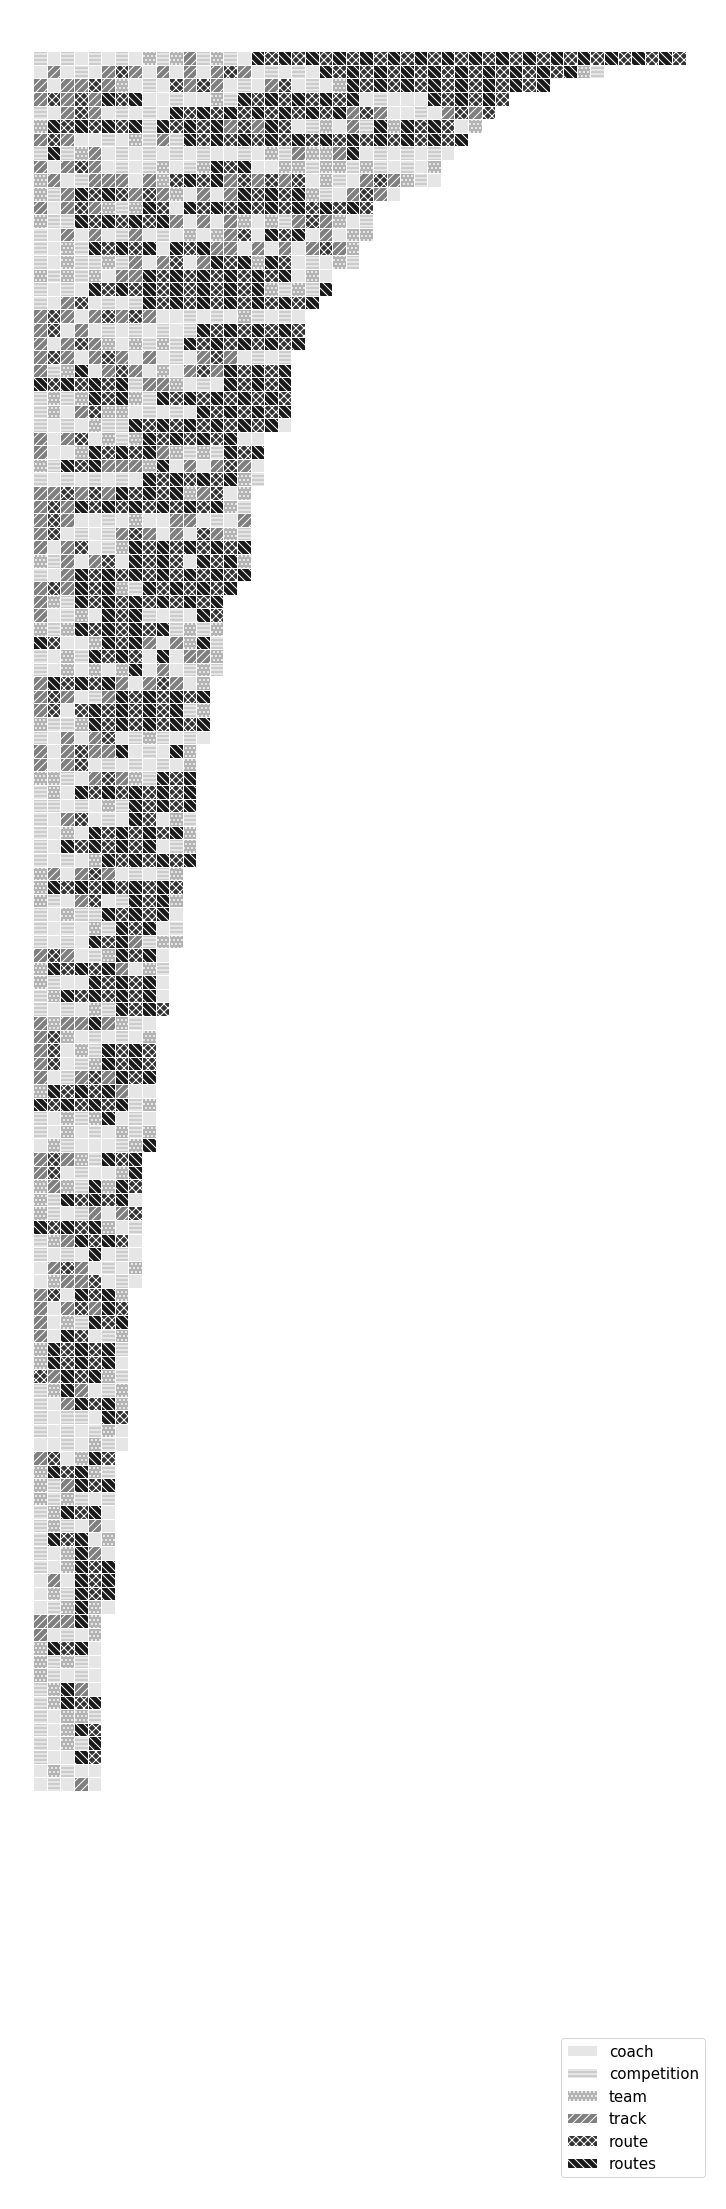

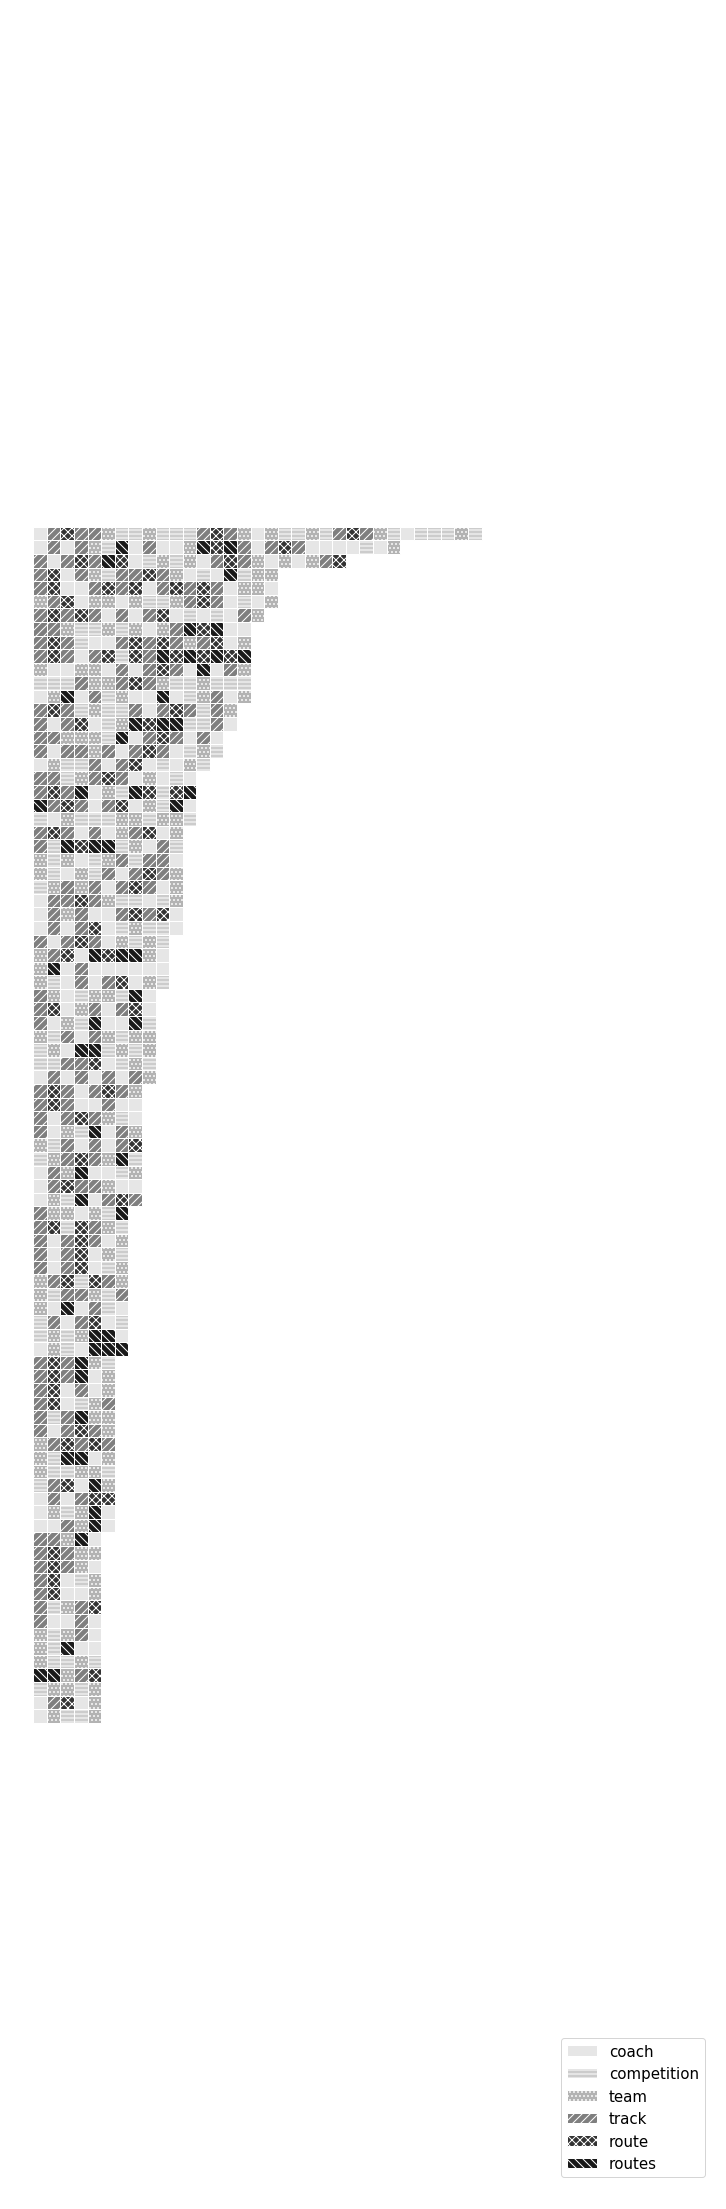

In [6]:
unique_values = np.unique(list(clustering_assignment.values()))
print(unique_values)
for value in unique_values:
    sequences = [x for x in clustering_assignment if clustering_assignment[x] == value]
    visualise_cluster(sequences, output='cluster_{}.svg'.format(value), bw=True)

In [7]:
# Take all sessions per user, and determine their profiles based on clustering results
sessions = pickle.load(open('../data/sessions.p', 'rb'))
for user in sessions:
    user_sessions = sessions[user]
    user_profile = {0: 0, 1: 0}
    proc_sequences = []
    for sequence in user_sessions:
        proc_seq = [x[0] for x in sequence if x[0] not in ['badges', 'bugreport', 'personal']][1:-1]
        if len(proc_seq)>1:
            user_profile[np.argmax([mc.get_probability(proc_seq) for mc in markov_chains])] += 1
            proc_sequences.append(proc_seq)
    total = sum(list(user_profile.values()))
    for k in user_profile:
        user_profile[k] /= total
    user_profile = {'gamer': user_profile[1], 'tracker': user_profile[0]}
    proc_sequences = sorted(proc_sequences, key=lambda x: (len(x), x))
    print(str(user_profile)+'---'+str(len(proc_sequences)))
    #visualise_cluster(proc_sequences, title=str(user_profile)+'---'+str(len(proc_sequences)), bw=True)

{'gamer': 0.6842105263157895, 'tracker': 0.3157894736842105}---38
{'gamer': 0.5625, 'tracker': 0.4375}---32
{'gamer': 0.625, 'tracker': 0.375}---8
{'gamer': 0.6176470588235294, 'tracker': 0.38235294117647056}---34
{'gamer': 0.43478260869565216, 'tracker': 0.5652173913043478}---23
{'gamer': 0.29411764705882354, 'tracker': 0.7058823529411765}---17
{'gamer': 0.0, 'tracker': 1.0}---1
{'gamer': 0.56, 'tracker': 0.44}---25
{'gamer': 0.5, 'tracker': 0.5}---2
{'gamer': 0.5555555555555556, 'tracker': 0.4444444444444444}---9
{'gamer': 1.0, 'tracker': 0.0}---1
{'gamer': 0.8333333333333334, 'tracker': 0.16666666666666666}---6
{'gamer': 0.6923076923076923, 'tracker': 0.3076923076923077}---13
{'gamer': 0.125, 'tracker': 0.875}---8
{'gamer': 1.0, 'tracker': 0.0}---1
{'gamer': 0.4074074074074074, 'tracker': 0.5925925925925926}---27
{'gamer': 0.625, 'tracker': 0.375}---8
{'gamer': 0.42857142857142855, 'tracker': 0.5714285714285714}---56
{'gamer': 0.4090909090909091, 'tracker': 0.5909090909090909}---22
